In [2]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib.image as mpimg
import pandas as pd
import os
import torch
import torchvision.models as models
import torchvision.transforms as transforms
#from torchvision.io import read_image
from PIL import Image
import seaborn as sns
import pandas as pd
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np




# PATHs
PROJECT_DATA_PATH='//home/bule/projects/MVTec_Visualizer/data/mvtec_anomaly_detection'
LOG_DIR= '/home/bule/projects/MVTec_Visualizer/tensorboard_logs'

In [3]:
FILENAME = 'MVTEC_WIDERESNET50_3thBlock_embeddings_df'
df = pd.read_pickle(os.path.join(PROJECT_DATA_PATH,FILENAME+'.pkl'))
image_paths=[pts[1:]for pts in df.index]
df = df.set_index(pd.Index(image_paths))

In [5]:
anomaly_categories = {
    'bottle': ['broken_large', 'broken_small', 'contamination'],
    'cable': ['bent_wire', 'cable_swap', 'combined', 'cut_inner_insulation', 'cut_outer_insulation', 'missing_cable', 'missing_wire', 'poke_insulation'],
    'capsule': ['crack', 'faulty_imprint', 'poke', 'squeeze'],
    'carpet': ['color', 'cut', 'hole', 'metal_contamination', 'thread'],
    'grid': ['bent', 'broken', 'glue', 'metal_contamination'],
    'hazelnut': ['crack', 'cut', 'hole', 'print'],
    'leather': ['color', 'cut', 'fold', 'glue', 'poke'],
    'metal_nut': ['bent', 'color', 'flip', 'scratch'],
    'pill': ['color', 'contamination', 'crack', 'faulty_imprint', 'pill_type'],
    'screw': ['manipulated_front', 'scratch_head', 'thread_side', 'thread_top'],
    'tile': ['crack', 'glue_strip', 'gray_stroke', 'oil'],
    'toothbrush': ['defective'],
    'transistor': ['bent', 'cut', 'damaged_case', 'misplaced'],
    'wood': ['color', 'combined', 'hole', 'liquid', 'scratch'],
    'zipper': ['broken_teeth', 'fabric_border', 'split_teeth', 'squeezed_teeth']
}


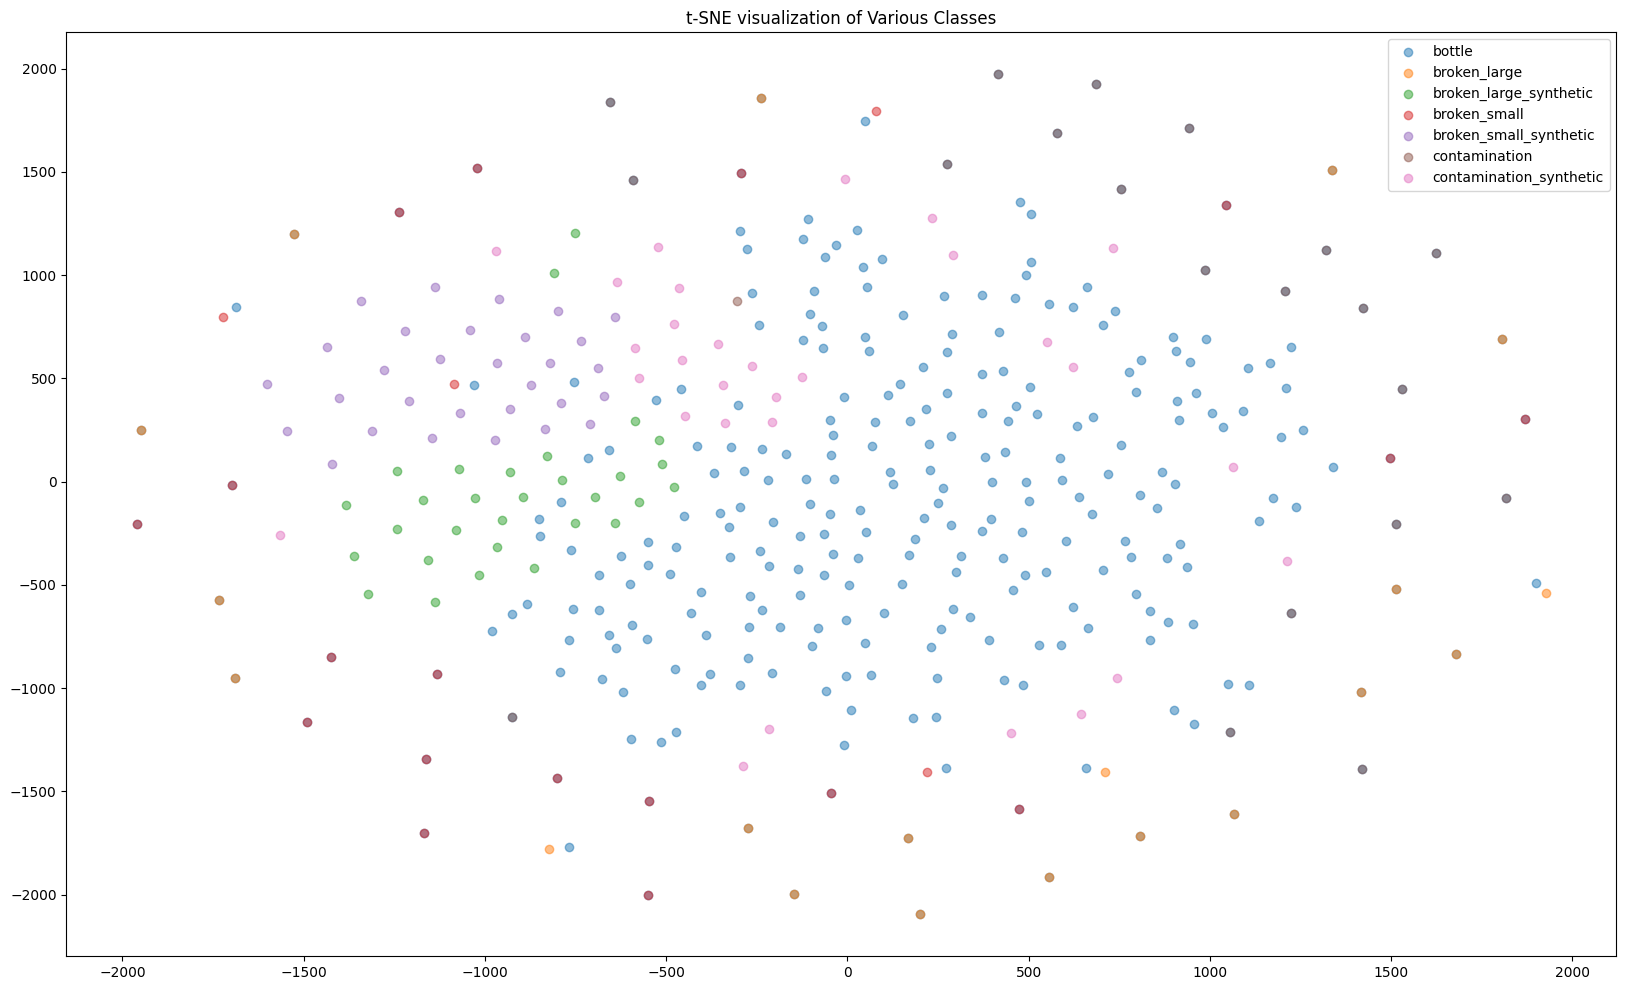

In [18]:
# structure : ["normal","anomaly","synthetic_anomaly","anomaly1","synthetic_anomaly1","anomaly2","synthetic_anomaly2".....]
category='bottle'
df_category = df[df.index.str.contains(category)]

all_data=[]
all_data.append(torch.Tensor(df_category.to_numpy()))
class_list=[category]

for anocat in anomaly_categories[category]:
    df_subcategory = df_category[df_category.index.str.contains(anocat)]
    df_subcategory.head()
    torch_array=torch.Tensor(df_subcategory.to_numpy())
    
    all_data.append(torch_array)
    class_list.append(anocat)
    
    means=torch_array.mean(dim=0)
    stds=torch.sqrt(torch_array.var(dim=0))
    rows = []
    for _ in range(30):
        row = torch.normal(means, stds)
        rows.append(row)
    new_samples = torch.stack(rows)
    all_data.append(new_samples)
    class_list.append(anocat+'_synthetic')
    
    
combined_samples = torch.cat(all_data).numpy()

# Create labels for each class
labels = []
for idx, data in enumerate(all_data):
    labels.extend([idx] * data.size(0))  # Each class gets a unique integer label
labels = np.array(labels)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=0)
reduced_data = tsne.fit_transform(combined_samples)

# Plotting
plt.figure(figsize=(20, 12))

# Iterate over each unique label to plot them separately
for i in range(len(all_data)):
    plt.scatter(reduced_data[labels == i, 0], reduced_data[labels == i, 1], label=f'{class_list[i]}', alpha=0.5)

plt.title('t-SNE visualization of Various Classes')
plt.legend()
plt.show()


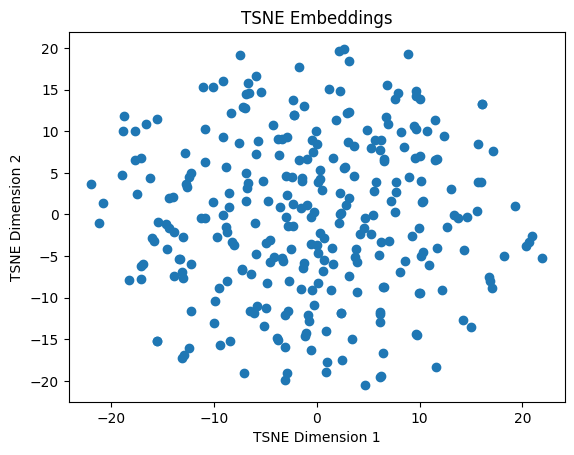

In [8]:

for category in list(anomaly_categories.keys()):
    # filter for category
    df_category = df[df.index.str.contains(category)]
    
    # Convert the resulting series of lists to a NumPy array
    numpy_array = df_category.to_numpy()
    # Apply t-SNE to reduce the dimensionality of the embeddings
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_jobs=-1, random_state=42)
    tsne_embeddings = tsne.fit_transform(numpy_array)
    
    # filter for anomaly and normal
    df_category_anomaly = df_category[~df_category.index.str.contains('good')]
    df_category_normal = df_category[df_category.index.str.contains('good')]
    
    # Create figure and GridSpec layout
    fig = plt.figure(figsize=(15, 15))  # Increase figure size to accommodate images
    gs = GridSpec(3, 2, figure=fig, height_ratios=[1, 1, 1], width_ratios=[3, 1])
    
    # t-SNE plot
    ax_tsne = fig.add_subplot(gs[0, 0])
    # Anomaly boxplot
    ax_anomaly = fig.add_subplot(gs[1, 0])  # Span full row
    # Normal boxplot
    ax_normal = fig.add_subplot(gs[2, 0])  # Span full row
    
    # Inner grid for sample images
    inner_gs = GridSpecFromSubplotSpec(3, 3, subplot_spec=gs[0, 1], wspace=0.1, hspace=0.1)

    # Define the color palette for the number of anomaly types + 1 for 'Normal'
    palette = sns.color_palette('tab10', len(anomaly_categories[category]) + 1)

    # idx contains the indexes of the normal samples
    idx = df_category.index.str.contains('good')
    
    anomaly_subclasses_idx = [df_category.index.str.contains(sub) for sub in anomaly_categories[category]]

    anomaly_subclasses_paths = {sub:df_category[df_category.index.str.contains(sub)].index[0] for sub in anomaly_categories[category]}

    # Plot the normal samples in blue
    ax_tsne.scatter(tsne_embeddings[idx, 0], tsne_embeddings[idx, 1], s=10, alpha=0.5, color='blue', label='Normal')

    # Plot each type of anomaly with a different color from the palette
    for i, sub_idx in enumerate(anomaly_subclasses_idx):
        ax_tsne.scatter(tsne_embeddings[sub_idx, 0], tsne_embeddings[sub_idx, 1], s=10, alpha=0.5, color=palette[i], label=anomaly_categories[category][i])

    ax_tsne.set_title(f't-SNE on WIDERESNET50 Embeddings: {category}')
    ax_tsne.legend()

    ## this takes very long to compute, uncomment if you want to see the boxplots...
    # # Boxplot for the anomaly category
    # sns.boxplot(data=df_category_anomaly, ax=ax_anomaly, linewidth=0.9, fliersize=0.05)
    # ax_anomaly.set_ylim(-1.5, 1.5)
    # ax_anomaly.set_title(f" {category}: Anomaly")
    # ax_anomaly.set_xticks([])  # Hide x-axis ticks

    # # Boxplot for the normal category
    # sns.boxplot(data=df_category_normal, ax=ax_normal, linewidth=0.9, fliersize=0.05)
    # ax_normal.set_ylim(-1.5, 1.5)
    # ax_normal.set_title(f" {category}: Normal")
    # ax_normal.set_xticks([])  # Hide x-axis ticks

    # Read and plot each sample image for the anomaly categories
    for i, anomaly in enumerate(anomaly_categories[category]):
        ax_image = fig.add_subplot(inner_gs[i])
        img = mpimg.imread(anomaly_subclasses_paths[anomaly])
        ax_image.imshow(img)
        ax_image.axis('off')  # Hide axes
        ax_image.set_title(anomaly, fontsize=8)

    # Adjust the layout so the plots are not overlapping
    plt.tight_layout()
    plt.show()

